In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
from sklearn.cluster import KMeans

In [2]:
# m: number of elements
# k: number of clusters
# dim: dimension of elements
# shape of mu: [k,dim]
# shape of x: [m,dim]
# shape of w: [dim]
# shape of d: [m,k]

# Functions

In [3]:
def softmax(v):
    e=np.exp(v)
    s=np.sum(e)
    return e/s

In [4]:
def wEuclidean(a,b,w): #weighted Euclidean metric
    return np.sqrt(np.dot(w,np.square(a-b)))
def Euclidean(a,b):
    return np.sqrt(np.sum(np.square(a-b)))
def distance_factory(w):
    def wEuclidean(a,b):
        return np.sqrt(np.dot(w,np.square(a-b)))
    return wEuclidean

In [5]:
#calculate the distance between data points x and centers mu
def distance_matrix(x,mu,w):
    k=np.shape(mu)[0]
    dim=np.shape(mu)[1]
    m=np.shape(x)[0]
    d_mat=np.zeros([m,k])
    for i in range(m):
        for j in range(k):
            d_mat[i][j]=wEuclidean(x[i],mu[j],w)
    return d_mat

In [6]:
def cost(d,e):
    #shape of d:[m,k]; d_ij is the weighted distance between x_i and mu_j
    #shape of e:[k,?]; e_i contains the list of element indexes that belongs to cluster i, these are labeled data
    total=0
    for i in range(np.shape(d)[0]):
        for pair in itertools.combinations(e[i],2):
            total+=(Euclidean(d[pair[0]],d[pair[1]])**2)
    return total

In [7]:
def gradient(x,w,e,eta):
    k=np.shape(mu)[0]
    dim=np.shape(mu)[1]
    m=np.shape(x)[0]
    dW=w*(1-w)
    dJ=np.zeros(dim)
    for i in range(k):
        tmp_e=list(itertools.combinations(e[i],2))
        
        # batch gradient
        if(len(tmp_e)>500):
            grad_e=random.choices(tmp_e,k=500)
            avg=500
        else:
            grad_e=tmp_e
            avg=len(grad_e)
            
        for pair in grad_e:
            a=int(pair[0])
            b=int(pair[1])
            dist=wEuclidean(x[a],x[b],w)
            if(dist==0):
                continue
            dJ+=(x[a]-x[b])/dist/avg
    return dJ*eta

In [8]:
def Jaccard(conf):
    return conf[0]/(conf[0]+conf[1]+conf[2])

def FMI(conf):
    return np.sqrt(conf[0]/(conf[0]+conf[1])*conf[0]/(conf[0]+conf[2]))

def Rand(conf):
    m=np.sum(conf)
    return (conf[0]+conf[3])/m

#above are values in range [0,1], bigger is better

In [9]:
#external evaluation of clustering performance
def cal_conf(y_true,y_kmeans):
    conf=np.zeros(4) #ss,sd,ds,dd
    num=np.shape(y_true)[0]
    for i in range(num):
        for j in range(i+1,num):
            if(y_true[i]==y_true[j]):
                if(y_kmeans[i]==y_kmeans[j]):
                    conf[0]+=1
                else:
                    conf[1]+=1
            else:
                if(y_kmeans[i]==y_kmeans[j]):
                    conf[2]+=1
                else:
                    conf[3]+=1
    return conf

# Kmeans Functions

In [10]:
def directed_kmeans_calculate_weight(x,e,it,eta):
    k=np.shape(e)[0]
    dim=np.shape(x)[1]
    m=np.shape(x)[0]
    
    #initialize g and mu
    g=np.ones(dim)
    mu=np.zeros([k,dim])
    for i in range(k):
        for j in range(len(e[i])):
            mu[i]+=x[int(e[i][j])]
        mu[i]/=np.size(e[i])
    descent=np.zeros([it,dim])
    d=np.zeros([m,k])
    hist_w=np.zeros([it,dim])
    
    for i in tqdm(range(it)):
        w=softmax(g)
        hist_w[i]=w
        descent[i]=gradient(x,mu,w,e,eta)
        g-=descent[i]
        
    index=np.zeros(m)
    num_element=np.zeros([k,1])
    for i in range(m):
        index[i]=np.argmin(d[i])
        #print(index[i])
        num_element[int(index[i])]+=1
    cache={"index":index,"mu":mu,"num_element":num_element,"g":g,"d":d,"descent":descent,"hist_w":hist_w}
    
    return w,cache

In [11]:
def wkmeans(X, k, distance_fn,max_iter=100):
    n_samples,n_features=X.shape
    centers=X[random.sample(range(n_samples),k)]
    
    for i in range(max_iter):
        assignments=np.array([np.argmin([distance_fn(x, c) for c in centers]) for x in X])
        new_centers=np.array([X[assignments==j].mean(axis=0) for j in range(k)])
        if np.allclose(centers, new_centers):
            break
        centers=new_centers
    return assignments,centers

In [12]:
def sklearn_kmeans(x,num):
    kmeans=KMeans(n_clusters=num,random_state=510)
    kmeans.fit(x)
    y_kmeans=kmeans.predict(x)
    centroids=kmeans.cluster_centers_
    return y_kmeans,centroids

# generated numerical test

In [13]:
def generate_gaussian(center,sd,num):
    dim=len(center)
    coord=np.zeros([num,dim])
    for i in range(dim):
        coord[:,i]=np.random.normal(loc=center[i], scale=sd,size=num)
    return coord

In [14]:
n=60
gen_data=np.zeros([16,n,2])
centers=np.array([[1,1],[1,2],[1,3],[1,4],[2,1],[2,2],[2,3],[2,4],[3,1],[3,2],[3,3],[3,4],[4,1],[4,2],[4,3],[4,4]])

In [15]:
for i in range(16):
    gen_data[i]=generate_gaussian(centers[i],0.15,n)

In [16]:
full_gen_data=gen_data.reshape([n*16,2])
x,y=full_gen_data[:,0],full_gen_data[:,1]

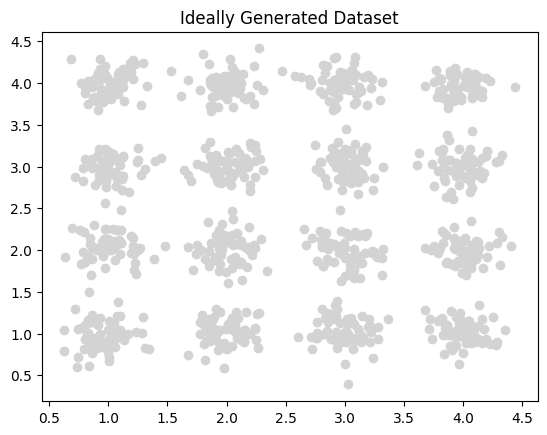

In [17]:
plt.scatter(x,y,c='lightgray')
a=random.choices(np.arange(240),k=30)
b=random.choices(np.arange(240,480),k=30)
plt.title("Ideally Generated Dataset")
plt.savefig("ideal_dataset")

## Regular Kmeans

In [30]:
y_reg_kmeans,reg_centroids=sklearn_kmeans(full_gen_data,4)

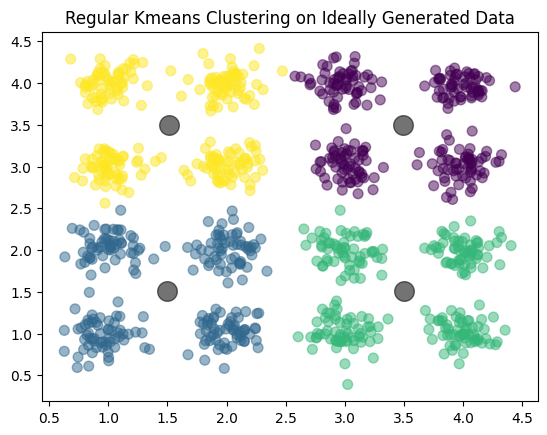

In [31]:
plt.scatter(
    full_gen_data[:, 0], 
    full_gen_data[:, 1],
    c=y_reg_kmeans, 
    s=50,    
    alpha=0.5
)

plt.scatter(
    reg_centroids[:, 0], 
    reg_centroids[:, 1], 
    c='black',
    s=200,
    alpha=0.55
)
plt.title("Regular Kmeans Clustering on Ideally Generated Data")
plt.savefig("reg_kmeans_ideal_data")

# Directed Kmeans--favor y over x

### manual input of weights

In [32]:
w=np.array([0.9,0.1])
y_reg_weighted_kmeans,reg_centroids=wkmeans(full_gen_data,4,distance_factory(w))

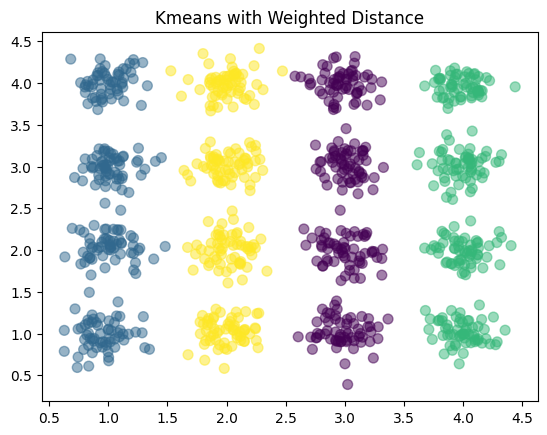

In [33]:
plt.scatter(
    full_gen_data[:, 0], 
    full_gen_data[:, 1],
    c=y_reg_weighted_kmeans, 
    s=50,    
    alpha=0.5
)


plt.title("Kmeans with Weighted Distance")
plt.savefig("weighted_kmeans")

### directed_kmeans weight learning

In [34]:
e=np.zeros([4,4*n])
e[0]=np.arange(4*n)
e[1]=np.arange(4*n,8*n)
e[2]=np.arange(8*n,12*n)
e[3]=np.arange(12*n,16*n)

In [35]:
gen_data_w,cache=directed_kmeans_calculate_weight(full_gen_data,e[0:1],500,0.05)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 188.54it/s]


In [36]:
gen_data_w

array([1.02395085e-08, 9.99999990e-01])

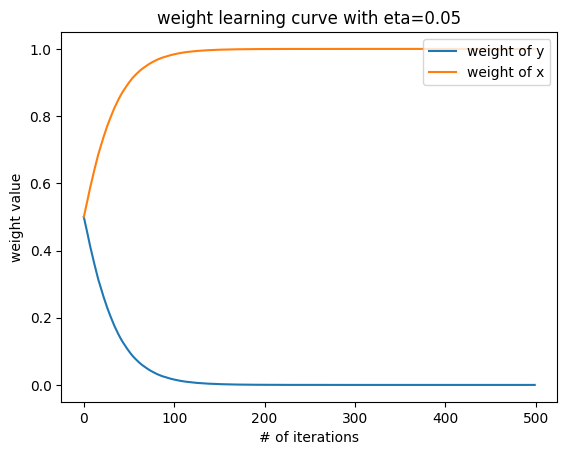

In [37]:
graphx=cache["hist_w"][:,0]
graphy=cache["hist_w"][:,1]
plt.plot(graphx,label="weight of y")
plt.plot(graphy,label="weight of x")

plt.legend(loc='upper right')
plt.xlabel("# of iterations")
plt.ylabel("weight value")
plt.title("weight learning curve with eta=0.05")
plt.savefig("learning_curve")

In [38]:
y_reg_learned_kmeans,reg_centroids=wkmeans(full_gen_data,4,distance_factory(gen_data_w))

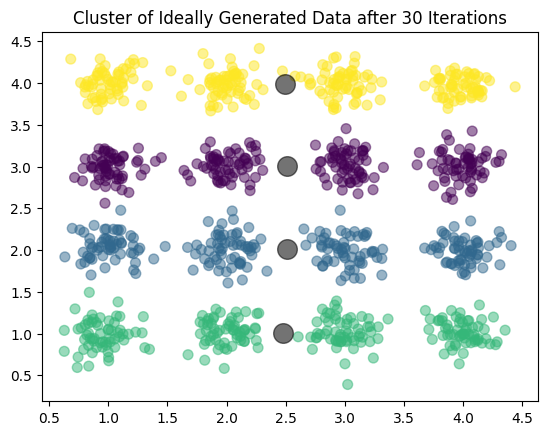

In [39]:
plt.scatter(
    full_gen_data[:, 0], 
    full_gen_data[:, 1],
    c=y_reg_learned_kmeans, 
    s=50,    
    alpha=0.5
)

plt.scatter(
    reg_centroids[:, 0], 
    reg_centroids[:, 1], 
    c='black',
    s=200,
    alpha=0.55
)
plt.title("Cluster of Ideally Generated Data after 30 Iterations")
plt.savefig("ideal_data_30_iter")